In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

Using TensorFlow backend.


In [2]:

"""
Requirements:

tensorflow >= 1.15.0
numpy
pandas

"""

'\nRequirements:\n\ntensorflow >= 1.15.0\nnumpy\npandas\n\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


###################################### Data Preparation ######################################
class DataLoader(object):
    def __init__(self, filename):
        
        '''
           Initiates a data class
              max_len : max length of the sequence
              tag2indx : mapping from tags to indices
              sentences: sequences
              labels: labels of tags
        
        
        '''
        
        self.data = pd.read_csv(filename, header = None, delimiter = "\t")
        self.data = self.data.rename(columns = {0: "Word", 1: "Tag"})
        self.tags =  np.unique(self.data['Tag'].to_list())
        self.data = self.data.fillna("END")
        self.pos=1
        self.max_len = 50
        self.sentences =[]
        self.labels = []
        self.tags2index = {t:i for i, t in enumerate(self.tags)}
        tempx = []
        tempy = []
        
        '''
        
           combining words into sentences and padding sentences to be equal to max_len
           populating self.sentences and self.labels
           
        '''
        for w,t in self.data.values:
            if w=="END" and t=="END":
                if len(tempx) <self.max_len:
                   tempx  += ["PADword"]*(self.max_len - len(tempx))
                   tempy  += [self.tags2index["O"]]*(self.max_len - len(tempy))
                    
                self.sentences.append(tempx[:self.max_len])
                self.labels.append(tempy[:self.max_len])
                tempx =[]
                tempy =[]
            elif w!="END" and t!="END":
                tempx.append(w)
                tempy.append(self.tags2index[t])
        del self.data

    
    def plot_histogram(self):
        
        '''
        
           plot histogram fo length of all sentences
           i.e helpful for deciding appropriate max_len value
        '''
        
        plt.figure()
        plt.hist([ len(d) for d in self.sentences])
        

In [4]:
def space_remove(x):
    del x

Total Number of Sentences: 2162


<Figure size 432x288 with 0 Axes>

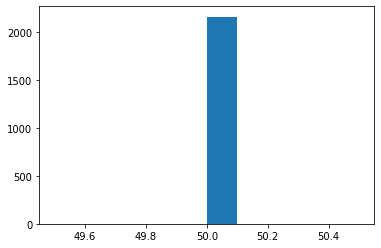

In [5]:
        

d = DataLoader("twitter_ritter.txt")

plt.figure()
d.plot_histogram()

X , Y = np.matrix(d.sentences) , np.matrix(d.labels)

n_sentences = X.shape[0]
print("Total Number of Sentences: {}".format(n_sentences))

'''
  Train Test Split
      80%  training data
      20%  testing data
      
'''
split = int(0.8*n_sentences)

Xtr, Xts, Ytr, Yts = X[:split, ...], X[split:, ...],  Y[:split, ...], Y[split:, ...]

'''
   Free space on the ram

'''
space_remove(X)
space_remove(Y)

In [6]:
################## Set Batch Size ###################

batch_size = 2

######################### Elmo Embedding function ##############

def ElmoEmbedding(x):
    
    '''
        Returns Elmo Embedding corresponding to each word in the sentence
         input:
             sentence
         output: 
            embedding of each word of the sentence
    '''
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,    tf.string)),"sequence_len": tf.constant(batch_size*[d.max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [7]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Flatten


################################ Model Initialization ##########################################################3
'''
   Model Construction
   
'''


class NRE():
    
    def __init__(self):
        '''
             Initializes model for NER
                 model : instance of constructed model
        '''
        
        input_text = Input(shape=(d.max_len,), dtype=tf.string)

        ############ Embedding Layer for Elmo Embedding  ##########

        embedding = Lambda(ElmoEmbedding, output_shape=(d.max_len, 1024))(input_text)

         ############ Bi Directional LSTM for tackling flows from both directions ##########

        x = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(embedding)
         ############ Bi Directional LSTM for tackling flows from both directions ##########

        x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                                   recurrent_dropout=0.2, dropout=0.2))(x)
        ############ Skip Connectional for residual Learning ##########

        x = add([x, x_rnn])  

        out = TimeDistributed(Dense(len(d.tags), activation="softmax"))(x)

        self.model = Model(input_text, out)

        self.model.summary()
    def compile_model(self, opt = "adam", loss = "sparse_categorical_crossentropy"):
        

        '''
            Compilation of Model
                optimizer = "adam"
                loss = "Sparse Categorical Cross Entropy"
        '''
        
        
        self.model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        
    def train_model(self, Xtr, Ytr, Xval, Yval, batch_size =2 , epoch = 2):
        
        '''
            Train Model
                Xtr, Ytr : training data
                Yval, Yval : Validation data
                batch_size = 2 (default)
                epoch = 2 (default)
                
        
        '''
        history = self.model.fit(Xtr, Ytr, validation_data=(Xval[:-1], Yval[:-1]), batch_size=batch_size, epochs=epoch, verbose=1)
        return history
        

In [8]:
nre = NRE()
nre.compile_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 1024)     6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

In [9]:
val_split = int(0.9 * Xtr.shape[0])

X_tr, X_val = Xtr[:val_split], Xtr[val_split:]

y_tr, y_val = Ytr[:val_split], Ytr[val_split: ]


############################ Space Efficiency ##########

space_remove(Xtr)
space_remove(Ytr)

print("X_tr shape: ", X_tr.shape)
print("Y_tr shape: ",y_tr.shape)


y_tr , y_val = y_tr[..., None], y_val[..., None]

X_tr shape:  (1556, 50)
Y_tr shape:  (1556, 50)


In [ ]:
############################# Model Training ##########################################33
train = True
if train:
    hist = nre.train_model(X_tr, y_tr, X_val, y_val)
    nre.model.save_weights("nre.h5")
else:
    nre.model.load_weights("nre")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1556 samples, validate on 172 samples
Epoch 1/2
 576/1556 [==========>...................] - ETA: 25:24 - loss: 0.1094 - accuracy: 0.9783

In [ ]:
"""
    Evaluate Model on Test dataset

"""

acc = nre.model.evaluate(Xts[:-1], Yts[:-1][..., None], batch_size = 2)[1]
print("Test Accuracy: {}".format(acc))

In [12]:
from nltk import word_tokenize 
idx2tags = {i:t for t, i in d.tags2index.items()}

class NER_tester():
    
    
    def __init__(self, text):
        '''
            input:
                text : text string to be tested
            Output:
                print predicted entities
        '''
        
        d_text = self.construct_test(test)
        ############### predict labels ###############
        pred_labels  = nre.model.predict(d_text)
        
        self.indices2tags(d_text, pred_labels)
        
    def construct_test(self, test):
        
        '''
        prepare test  string data for  model
        input:
          test string
        outpur:
          preprocessed string
        '''


        test = word_tokenize(test)

        test =[t for t in test if t.isalpha()]
        
        ################## assert length of sentence is less than max_len #################
        assert len(test)<= d.max_len

        #################### Pad array to be equal to batch size for elmo embedding ############### 
        
        test += ["PADword"]*(d.max_len -  len(test))
        

        return np.concatenate([np.array(test)[None, :], np.array(["PADword"]*d.max_len)[None, :]], axis = 0)
    
    def indices2tags(self, text, preds):
        '''
        Convert model prediction into tags and print predict entities

        input:
            text: test string
            preds: model prediction
        output:
            print import entities and probabilities

        '''

        assert text.shape[0]>1
        ############ Only first sample is useful, strip away padded information #################
        
        text = text[0]
        preds = preds[0]
        
        for i, p in enumerate(preds):
            label = idx2tags[np.argmax(p)]

            actual = ""
            
            ################  Print only identified entities ###########
         
            if label != "O":

               sort_labels = [(idx2tags[k], prob)  for k, prob in enumerate(p)]
               
               ################ Sort Lables according to Probability ###########

               sort_labels.sort(key = lambda x: x[1], reverse = True)

               for t, prob in sort_labels:
                    
                    ################## For all labels format upto 2 decimal for peobability ###########
                    if t != "O":
                        actual +=  t + " {:.02f}".format(prob) + "| "   

               print(text[i])
               print(label)
               print(actual)

In [14]:
######################### Please Enter Input String of length less than 50 ##############################

test = "I live in USA."

NER_tester(test)

USA
B-geo-loc
B-geo-loc 0.96| B-company 0.01| B-facility 0.01| I-geo-loc 0.00| B-person 0.00| B-other 0.00| B-musicartist 0.00| B-product 0.00| I-other 0.00| B-sportsteam 0.00| I-facility 0.00| I-person 0.00| B-movie 0.00| B-tvshow 0.00| I-company 0.00| I-sportsteam 0.00| I-product 0.00| I-musicartist 0.00| I-movie 0.00| I-tvshow 0.00| nan 0.00| 
